<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Making and customizing plots of metrics with MAF</b> <br>
Contact author: Eric Neilsen<br>
Questions welcome at <a href="https://community.lsst.org/c/sci/survey-strategy">community.lsst.org/c/sci/survey-strategy</a> and the <a href="https://lsstc.slack.com/archives/C2LTWTP5J">#sims_operations</a> slack channel.<br>
Find additional MAF documentation and resources at <a href="https://rubin-sim.lsst.io">rubin-sim.lsst.io</a>. <br>

The "Introduction to MAF" notebook shows how to make simple default plots using MAF, and gives a few examples of basic customization.
The "Comparing runs" notebook expands on this, showing how to show metrics from different runs on the same plot, so that they may be compared.
This notebook expands on these, showing how to further customize plots, or even create entirely new ones.

## 1. Notebook preparation

The following is a development style aid; only uncomment if developing the notebook:

In [1]:
# %load_ext lab_black
# %load_ext pycodestyle_magic
# %flake8_on --ignore E501,W505

Import modules used by this notebook:

In [2]:
import rubin_sim
from rubin_sim import maf

Record what version of MAF the current execution of the notebook used:

In [3]:
rubin_sim.__version__

'0.14.0'

## 2. Basic plotting with defaults

We begin by calculating some sample metrics and plotting them using default tools:

For this example, use the baseline data that can be downloaded following the `rubin_sim` install instructions.

In [4]:
from os import path

opsim_fname = rubin_sim.data.get_baseline()
run_name = path.splitext(path.basename(opsim_fname))[0]
print(f"Using {run_name}, to be read from {opsim_fname}")

Using baseline_v2.1_10yrs, to be read from /Users/lynnej/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db


Now, follow the procedure described in the "Introduction to MAF" to calculate some metrics and show some default plots.

Create a couple of metric bundles:

In [5]:
airmass_metric_bundle = maf.MetricBundle(
    metric=maf.CountMetric(col="airmass"),
    slicer=maf.OneDSlicer(slice_col_name="airmass", bin_min=1.0, bin_max=2.5, bin_size=0.05),
    constraint="",
    run_name=run_name,
)

In [6]:
depth_map_bundle = maf.MetricBundle(
    metric=maf.Coaddm5Metric(),
    slicer=maf.HealpixSlicer(nside=64),
    constraint="filter='g'",
    run_name=run_name,
)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Create a bundle group, and use it to actually compute the metrics:

In [7]:
bgroup = maf.MetricBundleGroup(
    [airmass_metric_bundle, depth_map_bundle], opsim_fname
)
bgroup.run_all()

One of the most common ways to make plots is to use the bundle groups `plot_all` method, which makes default plots for each metric bundle in the bundle group:

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:148: UserWarning: Optimal bin calculation tried to make 243 bins, returning 200
  warnings.warn(


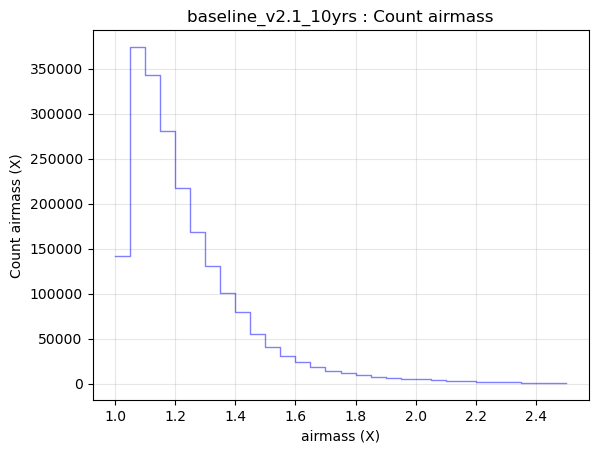

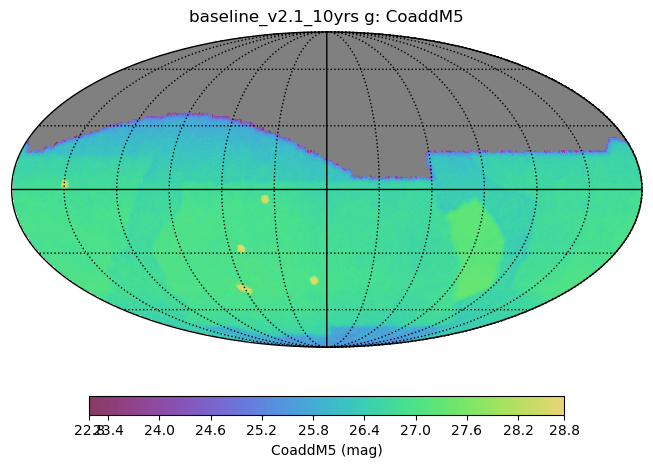

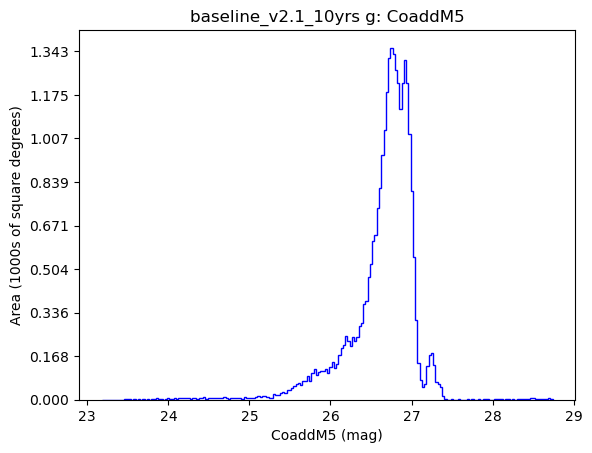

In [8]:
bgroup.plot_all(closefigs=False)

What `MetricBundleGroup.plot_all` is actually doing here is iterating through each bundle group, and calls the `plot` method of each metric bundle. We can call these directly on each bundle, using the bundle objects themselves:

{'BinnedData': 1}

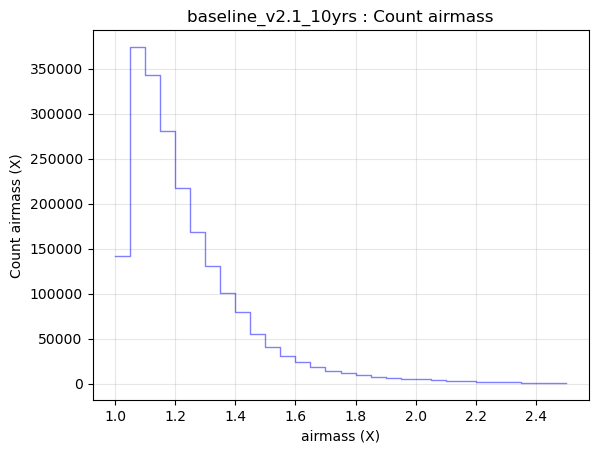

In [9]:
airmass_metric_bundle.plot()

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:148: UserWarning: Optimal bin calculation tried to make 243 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

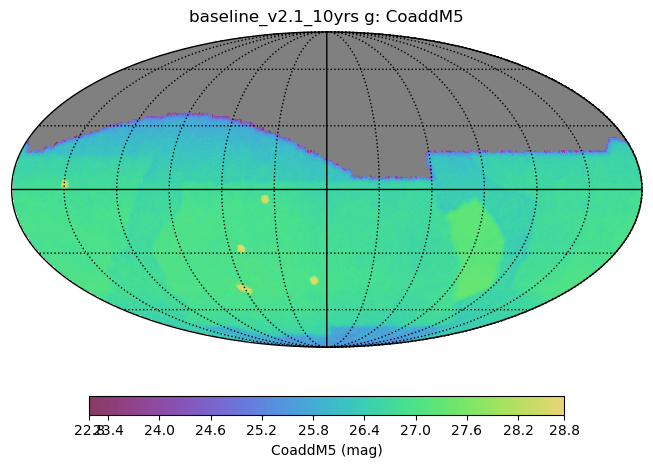

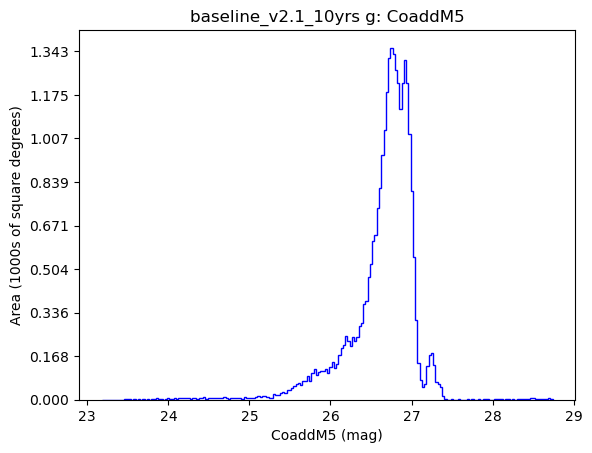

In [10]:
depth_map_bundle.plot()

Each instance of `maf.MetricBundle` has a `plot_funcs` member, whose value is a list of `MAF` "plotter" objects (usually instances of subclasses of `rubin_sim.maf.plots.BasePlotter`).

Each slicer has a list of default plotter classes, and if no plotters are otherwise specified, the plotter objects for a metric bundle are initialized to instances of the plotter classes provided by the `plot_func` member of the metric bundle's slicer.

So, the reason why the `depth_map_bundle.plot` command above generated a healpix sky map and histogram of values is that the slicer it was initialized with, `HealpixSlicer`, had these classes is its `plot_funcs`:

In [11]:
depth_map_bundle.slicer.plot_funcs

[rubin_sim.maf.plots.spatial_plotters.HealpixSkyMap,
 rubin_sim.maf.plots.spatial_plotters.HealpixHistogram]

## 3. Changing which plotters are used

You can also change which plotters are used for each metric.

For example, we can use the `HealpixPowerSpectrum` plotter in addition to (or instead of) the default plotters for a metric bundle with a `HealpixSlicer`:

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


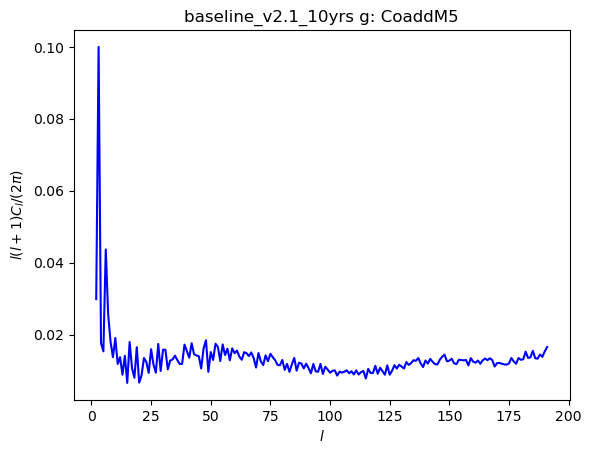

In [12]:
depth_map_bundle2 = maf.MetricBundle(
    metric=maf.Coaddm5Metric(),
    slicer=maf.HealpixSlicer(nside=64),
    constraint="filter='g'",
    plot_funcs=[maf.HealpixPowerSpectrum()],
    run_name=run_name,
)

bgroup2 = maf.MetricBundleGroup([depth_map_bundle2], opsim_fname)
bgroup2.run_all()
bgroup2.plot_all(closefigs=False)

You can also change the plot functions after metrics are calculated, and replot. For example, let's say we really wanted both the map and power spectrum:

{'SkyMap': 1, 'PowerSpectrum': 2}

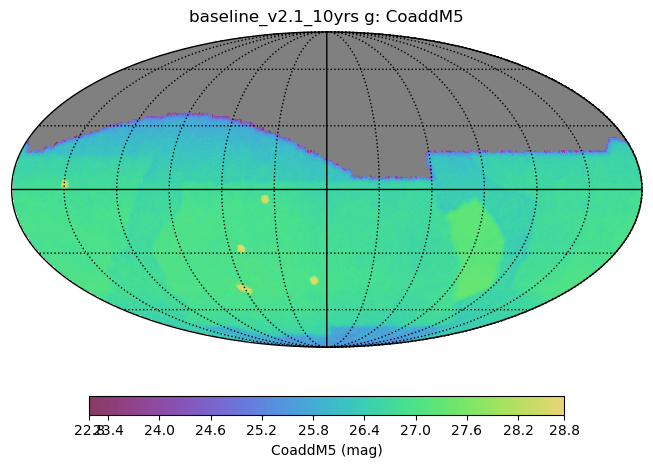

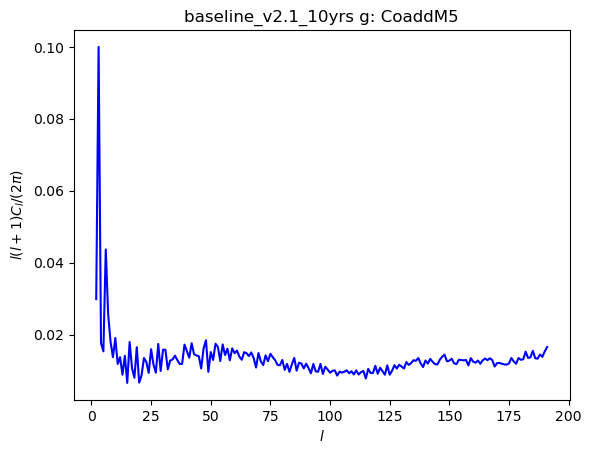

In [13]:
depth_map_bundle2.set_plot_funcs([maf.HealpixSkyMap(), maf.HealpixPowerSpectrum()])
depth_map_bundle2.plot()

## 4. Customizing plot parameters

The parameters of each plot can be customized using a dictionary, `plot_dict`, passed to the plotter.

The `plot_dict` can be customized at the time the metric bundle is created. For example, to move the sky map so that the south pole is in the center of the projection, and tweak the color scale:

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


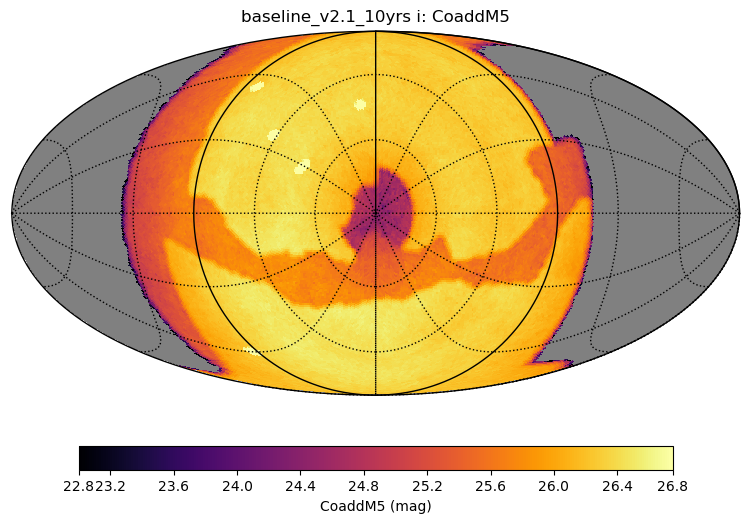

In [14]:
import matplotlib.pyplot as plt

depth_map_bundle3 = maf.MetricBundle(
    metric=maf.Coaddm5Metric(),
    slicer=maf.HealpixSlicer(nside=64),
    constraint="filter='i'",
    plot_funcs=[maf.HealpixSkyMap()],
    plot_dict={
        "rot": (0, -90, 0),
        "color_min": 23,
        "color_max": 26.75,
        "cmap": plt.get_cmap("inferno"),
        "figsize": (8, 5),
    },
    run_name=run_name,
)

bgroup3 = maf.MetricBundleGroup([depth_map_bundle3], opsim_fname)
bgroup3.run_all()
bgroup3.plot_all(closefigs=False)

You can also change the `plot_dict` after metrics have been computed, and replot. For example, let's use a Lambert Azimuthal Equal Area projection for the sky map, using the metric values we have already calculated:

{'SkyMap': 1}

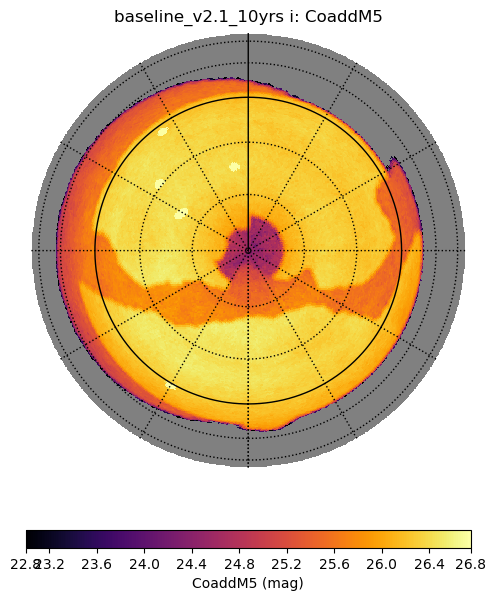

In [15]:
import matplotlib.pyplot as plt
import healpy as hp

depth_map_bundle3.set_plot_dict(
    {
        "rot": (0, -90, 0),
        "colorMin": 23,
        "colorMax": 26.75,
        "cmap": plt.get_cmap("inferno"),
        "visufunc": hp.azeqview,
        "lamb": True,
        "reso": 17.5,
        "figsize": (6, 6),
    }
)
depth_map_bundle3.plot()

Each plotter has its own set of keys that it can accept in its `plot_dict`. You can take a look at the options and their default values by looking at the `defaultPlotDict` member of the plotter.

Remembering that the `plot_funcs` member of an instance of `MetricBundle` is a list of the plotters, grab the first element (and in this case, only) element and show its `default_plot_dict`: 

In [16]:
depth_map_bundle3.plot_funcs[0].default_plot_dict

{'title': None,
 'xlabel': None,
 'label': None,
 'log_scale': False,
 'percentile_clip': None,
 'norm_val': None,
 'zp': None,
 'cbar_orientation': 'horizontal',
 'cbar_format': None,
 'cmap': <matplotlib.colors.LinearSegmentedColormap at 0x19f458b20>,
 'cbar_edge': True,
 'n_ticks': 10,
 'color_min': None,
 'color_max': None,
 'x_min': None,
 'x_max': None,
 'y_min': None,
 'y_max': None,
 'labelsize': None,
 'fontsize': None,
 'figsize': None,
 'subplot': 111,
 'mask_below': None,
 'rot': (0, 0, 0),
 'flip': 'astro',
 'coord': 'C',
 'nside': 8,
 'reduce_func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'visufunc': <function healpy.visufunc.mollview(map=None, fig=None, rot=None, coord=None, unit='', xsize=800, title='Mollweide view', nest=False, min=None, max=None, flip='astro', remove_dip=False, remove_mono=False, gal_cut=0, format='%g', format2='%g', cbar=True, cmap=None, badcolor='gray', bgcolor='white', notext=False, norm

## 5. Available plotters

MAF supplies a variety of plotters:

In [17]:
def print_subclasses(klass):
    for klass in klass.__subclasses__():
        print(klass.__name__)
        print_subclasses(klass)


print_subclasses(maf.BasePlotter)

HealpixSkyMap
HealpixPowerSpectrum
HealpixHistogram
BaseHistogram
BaseSkyMap
HealpixSDSSSkyMap
LambertSkyMap
HourglassPlot
OneDBinnedData
TwoDSubsetData
OneDSubsetData
FOPlot
SummaryHistogram
NeoDistancePlotter
TwoDMap
VisitPairsHist
MetricVsH
MetricVsOrbit
MetricVsOrbitPoints
NightPointingPlotter
GeneralHourglassPlot
RangeHourglassPlot
RangeHourglassCategoricalPlot
MonthHourglassPlot
MonthHourglassCategoricalPlot
MonthHourglassUsePlot
YearHourglassPlot
YearHourglassCategoricalPlot
YearHourglassUsePlot
XyPlotter


The standard python `help` utility will provide documentation on each:

In [18]:
help(maf.HealpixPowerSpectrum)

Help on class HealpixPowerSpectrum in module rubin_sim.maf.plots.spatial_plotters:

class HealpixPowerSpectrum(rubin_sim.maf.plots.plot_handler.BasePlotter)
 |  Method resolution order:
 |      HealpixPowerSpectrum
 |      rubin_sim.maf.plots.plot_handler.BasePlotter
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, metric_value, slicer, user_plot_dict, fignum=None)
 |      Generate and plot the power spectrum of metric_value (calculated on a healpix grid).
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from rubin_sim.maf.plots.plot_handler.BasePlotter:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [19]:
help(maf.FOPlot)

Help on class FOPlot in module rubin_sim.maf.plots.special_plotters:

class FOPlot(rubin_sim.maf.plots.plot_handler.BasePlotter)
 |  Special plotter to generate and label fO plots.
 |  
 |  Method resolution order:
 |      FOPlot
 |      rubin_sim.maf.plots.plot_handler.BasePlotter
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, metric_value, slicer, user_plot_dict, fignum=None)
 |      Parameters
 |      ----------
 |      metric_value : numpy.ma.MaskedArray
 |          The metric values calculated with the 'Count' metric and a healpix slicer.
 |      slicer : rubin_sim.maf.slicers.HealpixSlicer
 |      user_plot_dict: dict
 |          Dictionary of plot parameters set by user (overrides default values).
 |          Note that asky and n_visits values set here and in the slicer should be consistent,
 |          for plot labels and summary statistic values to be consistent.
 |      fignum : int
 |          Matplotlib figure number to use (default = None, s

## 6. Writing a new plotter

Let's say we want to create a polar plot that shows the number of visits as a function of R.A.
We can use the existing `OneDSlicer` to divide the visits up into slices by R.A. and `CountMetric` to count the visits in each slice, but the default plotter gives a cartesion plot:

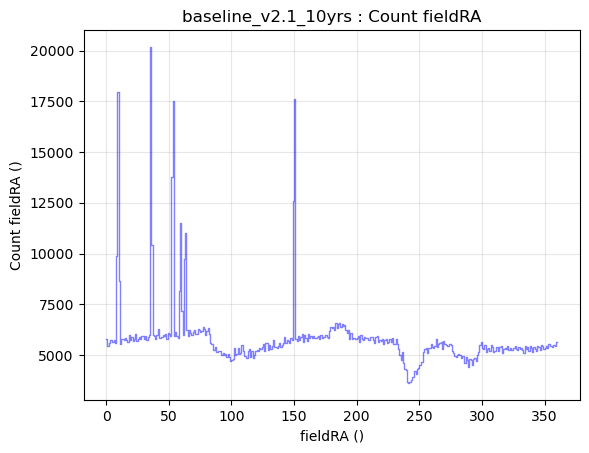

In [20]:
ra_dist_bundle = maf.MetricBundle(
    metric=maf.CountMetric(col="fieldRA"),
    slicer=maf.OneDSlicer(slice_col_name="fieldRA", bin_min=0.0, bin_max=360.0, bin_size=1),
    run_name=run_name,
)

bgroup4 = maf.MetricBundleGroup([ra_dist_bundle], opsim_fname)
bgroup4.run_all()
bgroup4.plot_all(closefigs=False)

To create a new plotter, let's take a look at the base class for plotters to see what they should look like:

In [21]:
%psource maf.BasePlotter

We need to create a subclass of `maf.BasePlotter` that sets customizes `__init__` and `__call__` to implement the plot we want.

Our `__init__` will need to set three members:
- `self.plot_type` should be set to a string that describes our new plot,
- `self.object_plotter` should be set to `True` if the metric it plots can be an array of python objects, `False` if it must by an array of numbers.
- `self.default_plot_dict` should be a dictionary of parameters that customize the plot. Some keys in this dictionary may be set automatically by the MAF plotting machinery (`maf.PlotHandler.set_plot_dicts`), and so should be supported if they make sense for the plot in question: `title`, `label`, `color`, `cbarFormat`, `xlabel`, `ylabel`. Others are conventional in MAF, and used across multiple already implemented plotters: `x_min`, `x_max`, `yMin`, `yMax`, `alpha`, `logScale`, `cmap`, and `subplot`.

Our `__call__` method will need to accept four arguments:
- `metric_values`, the `numpy.array` of values computed by whatever metric we are plotting.
- `slicer`, the `maf` slicer object corresponding to the computed metrics. Plotters will typically need to extract values from the `slice_points` member of the `slicer` object.
- `user_plot_dict`, a dictionary of parameters that set details of how the plot is to be plotted, overriding any values set in `self.default_plot_dict` by the `__init__` method.
- `fignum`, an (optional) `matplotlib` figure number that sets the figure on which to make the plot.

The `__call__` method needs to return the `matplotlib` `fignum` of the figure it added the plot to.

The `__call__` method will typically consist of several sections:
1. Code that verifies that the `metric_values` and `slicer` it is passed can be used with the plotter.
2. Code that combines values in `self.default_plot_dict` and the `user_plot_dict` passed as an argument to form a `plot_dict` that provides the parameters actually used. This will probably look something like this:
        plot_dict = {}
        plot_dict.update(self.default_plot_dict)
        plot_dict.update(user_plot_dict)
3. Code that creates or retrieves the necessary instances of `matplotlib.figure.Figure` and `matplotlib.axes.Axes`. Other code in MAF can make assumptions about the use of `pyplot` figures and figure numbers (`fignum`s), so it's best to stick with the `matplotlib.pyplot` interface rather than use the `matplotlib` OO interface directly, for example:
        fig = plt.figure(fignum, figsize=plotDict["figsize"])
        ax = plt.subplot(plotDict["subplot"])
4. Code that extracts data as passed in `metric_values` and `slicer` into forms that can be passed to `matplotlib` plotting methods. This transformation may not be necessary in all cases.
5. Code that actually plots the data.
6. Code that sets `matplotlib` object parameters to "decorate" the plot according to values set in the `plot_dict`.

Pulling all these elements together, let's implement a plotter that plots a metric in polar coordinates:

In [22]:
import numpy as np
import matplotlib.pyplot as plt


class OneDPolarPlotter(maf.BasePlotter):
    def __init__(self):

        # Call the constructor of the superclass to get
        # generic defaults for common
        # self.defaulPlotDict keys, such as
        # title, xlabel, etc.
        super().__init__()

        # Customize our plotters members for our new plot
        self.plot_type = "PolarBinnedData"
        self.object_plotter = False
        self.default_plot_dict.update(
            {
                "west_right": True,
                "zero_location": "N",
                "degrees": True,
                "subplot": 111,
            }
        )

    def __call__(self, metric_values, slicer, user_plot_dict, fignum=None):
        # Make sure we are getting data from a slicer we can deal with
        if "bins" not in slicer.slice_points:
            raise ValueError(
                f'{self.plot_type} can only be used with slicers that provide a "bins" slicePoint.'
            )

        # **** Build the plotDict we will actually use ****
        plot_dict = {}
        plot_dict.update(self.default_plot_dict)
        plot_dict.update(user_plot_dict)

        # **** add an axis in polar coordinates ****

        # Exctract elemens of plotDict that need to be passed to plt.figure
        fig_kwargs = {k: v for k, v in plot_dict.items() if k in ["figsize"]}

        fig = plt.figure(fignum, **fig_kwargs)
        ax = plt.subplot(plot_dict["subplot"], projection="polar")

        # **** Excract values for plotting from metricValues and the slicer

        # Plot each value in the center of its bin
        bin_starts = slicer.slice_points["bins"][:-1]
        bin_widths = np.diff(slicer.slice_points["bins"])
        bin_centers = bin_starts + bin_widths / 2

        if plot_dict["degrees"]:
            bin_centers_rad = np.radians(bin_centers)
        else:
            bin_centers_rad = bin_centers

        # **** Actually make the plot ****

        # Exctract elemens of plotDict that need to be passed to ax.plot
        plot_kwargs = {k: v for k, v in plot_dict.items() if k in ["label", "color"]}

        ax.plot(bin_centers_rad, metric_values, **plot_kwargs)

        # **** set our axis labels ****

        # Get the label text
        xlabel = plot_dict["xlabel"] if "xlabel" in plot_dict else ax.get_xlabel()
        ylabel = plot_dict["ylabel"] if "ylabel" in plot_dict else ax.get_ylabel()

        # Exctract elemens of plotDict that need to be passed to ax.set_Alabel
        label_kwargs = {k: v for k, v in plot_dict.items() if k in ["fontsize"]}

        ax.set_xlabel(xlabel, **label_kwargs)
        ax.set_ylabel(ylabel, **label_kwargs)

        # **** Format the ticks ****

        # Exctract elemens of plotDict that need to be passed to ax.tick_params
        tick_kwargs = {k: v for k, v in plot_dict.items() if k in ["labelsize"]}

        ax.tick_params(**tick_kwargs)

        # **** Set the title ****
        ax.set_title(plot_dict["title"])

        # **** Set polar plot parameters ****

        # Match the appearance of the sky as seen from the ground?
        if plot_dict["west_right"]:
            ax.set_xlim(reversed(ax.get_xlim()))

        ax.set_theta_zero_location(plot_dict["zero_location"])

        return fig.number

Now, use this plotter with the `ra_dist_bundle` metric bundle (created above):

{'PolarBinnedData': 1}

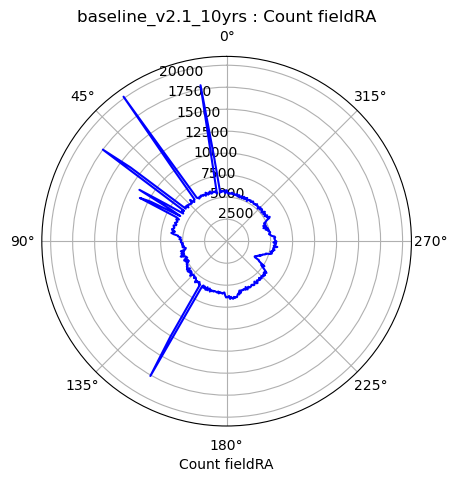

In [23]:
ra_dist_bundle.set_plot_funcs([OneDPolarPlotter()])
ra_dist_bundle.plot()

## 7. Overplotting multiple metrics

If you want to overplot multiple metrics on a single plot, you can use build your own instance of `maf.PlotHandler` and use it to do this.

For example, let's say we want to separate the different visits in our polar visit count plot (created above) by band, and plot each on the same plot, but with different colors.

Start by creating a list of instances of `MetricBundle`, one instance for each band:

In [24]:
def make_ra_count_bundle(band, run_name):
    bundle = maf.MetricBundle(
        metric=maf.CountMetric(col="fieldRA"),
        slicer=maf.OneDSlicer(
            slice_col_name="fieldRA", bin_min=0.0, bin_max=360.0, bin_size=1
        ),
        plot_funcs=[OneDPolarPlotter()],
        constraint=f"filter='{band}'",
        run_name=run_name,
    )
    return bundle


ra_count_bundles = [make_ra_count_bundle(b, run_name) for b in "ugrizy"]
ra_count_bundles

We then need to actually calculate metric values for each bundle in the list:

In [25]:
bgroup = maf.MetricBundleGroup(ra_count_bundles, opsim_fname)
bgroup.run_all()

If we just ran `bgroup.plot_all` now, it would create a separate figure for each filter, which is not what we want.

To make curves for each band distinct, we should create a separate `plot_dict` for each metric bundle.

Create a list of `plot_dict`s, in the same order in which we created the list of metric bundles: the nth `plot_dict` will be applied to the nth `MetricBundle`:

In [26]:
desc_band_colors = {
    "u": "#56b4e9",
    "g": "#008060",
    "r": "#ff4000",
    "i": "#850000",
    "z": "#6600cc",
    "y": "#000000",
}

ra_count_plot_dicts = [
    {"color": desc_band_colors[b], "label": f"Visits in {b}", "figsize": (8, 8)}
    for b in "ugrizy"
]

Now explicitly create our own `PlotHandler`, set its lists of `MetricBundle`s and `plot_dict`s, and plot it using our custom `OneDPolarPlotter`:

1

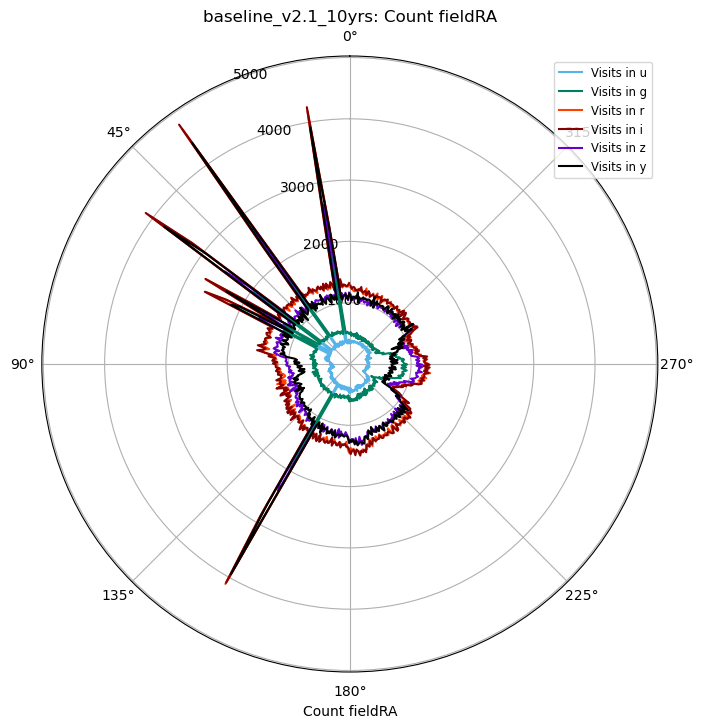

In [27]:
plot_handler = maf.PlotHandler()
plot_handler.set_metric_bundles(ra_count_bundles)
plot_handler.set_plot_dicts(ra_count_plot_dicts)
plot_handler.plot(plot_func=OneDPolarPlotter())

The `savefig`, `out_dir`, and `fig_format` arguments of the `PlotHandler` constructor above can be used to set whether the plot is saved, and the directory and format it which it is saved. The root of the file name of the saved file can be set using the `outfile_root` argument of the `PlotHandler.plot` method.

**Acknowledgements:** These tutorial notebooks have benefited from previous work in MAF tutorials, including not only the [tutorial notebooks in sims_MAF-contrib](https://github.com/LSST-nonproject/sims_maf_contrib/tree/master/tutorials) but also those by  Weixiang Yu, Gordon Richards, and Will Clarkson in their [LSST_OpSim](https://github.com/RichardsGroup/LSST_OpSim) repository, inspired the material to be included here. Stylistic elements of these notebooks were guided by the DP0.1 notebooks developed by Melissa Graham and the Rubin Observatory Community Engagement Team.